In [1]:
!pip install PyDrive

In [2]:
from pydrive.auth import GoogleAuth
from pydrive.drive import GoogleDrive
from google.colab import auth
from oauth2client.client import GoogleCredentials

In [3]:
auth.authenticate_user()
gauth = GoogleAuth()
gauth.credentials = GoogleCredentials.get_application_default()
drive = GoogleDrive(gauth)

In [4]:
#Only_faces 
downloaded = drive.CreateFile({'id':"1XUGgZx6GwVUmLR1YpCSB28pv5B3GqnUZ"})   
downloaded.GetContentFile('Only_faces.zip')

In [5]:
from zipfile import ZipFile

with ZipFile("Only_faces.zip", 'r') as file:
    file.extractall()
file.close()

In [6]:
VAL_LOC = "/content/Only_faces/Testing_Unmasked"
TRAIN_LOC = "/content/Only_faces/Training"
MASKED_LOC = "/content/Only_faces/Testing_masked"

In [17]:
!pip install livelossplot

In [7]:
import tensorflow as tf
from tensorflow.keras.layers import *
from tensorflow.keras.models import *
from tensorflow.keras.applications import *
from tensorflow.keras.preprocessing.image import *
from tensorflow.keras.optimizers import *
from tensorflow.keras.metrics import *

from tensorflow.keras.utils import plot_model
from tensorflow.keras.callbacks import *
from keras import backend as K

from imutils import build_montages
import os
from PIL import Image
import cv2
from collections import Counter
import imutils
from imutils import paths

from scipy.spatial.distance import cosine, euclidean
import numpy as np
import pandas as pd
from glob import glob
import matplotlib.pyplot as plt
import seaborn as sns

from tqdm import tqdm

from plotly.subplots import make_subplots
import plotly.express as px
import plotly.graph_objects as go
import plotly as ply

from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
ply.offline.init_notebook_mode(connected=True)

import warnings
warnings.filterwarnings('ignore')

%matplotlib inline

In [8]:
train_data = TRAIN_LOC
val_data = VAL_LOC
masked_data = MASKED_LOC

train_names = []; val_names = []; masked_names = []
train_names_count = []; val_names_count = []; masked_names_count = []

for class_ in os.listdir(train_data):
    train_names.append(class_)
    train_names_count.append(len(os.listdir(os.path.join(train_data, class_))))

for class_ in os.listdir(val_data):
    val_names.append(class_)
    val_names_count.append(len(os.listdir(os.path.join(val_data, class_))))

for class_ in os.listdir(masked_data):
    masked_names.append(class_)
    masked_names_count.append(len(os.listdir(os.path.join(masked_data, class_))))
fig = make_subplots(rows=1, cols=3)
fig.add_trace(go.Bar(name='training', x=train_names, y=train_names_count), row = 1, col = 1)
fig.add_trace(go.Bar(name='validation', x=val_names, y=val_names_count), row = 1, col = 2)
fig.add_trace(go.Bar(name='testing_masked', x=masked_names, y=masked_names_count), row = 1, col = 3)

fig.update_layout(title_text="Data", title_x = 0.5)
fig.show(renderer="colab")

In [67]:
train_datagen = ImageDataGenerator(rescale = 1./255,
                                   horizontal_flip = True)

val_datagen = ImageDataGenerator(rescale = 1./255)

train_gen = train_datagen.flow_from_directory(train_data,
                                            target_size = (224, 224),
                                            batch_size = 64,
                                            class_mode = 'categorical')

val_gen = val_datagen.flow_from_directory(val_data,
                                            target_size = (224, 224),
                                            batch_size = 64,
                                            class_mode = 'categorical')

Found 2252 images belonging to 6 classes.
Found 952 images belonging to 6 classes.


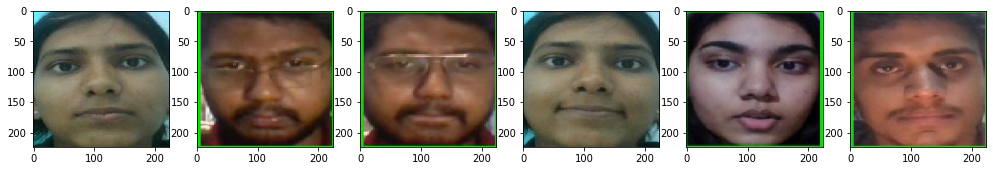

In [98]:
#Sample Images
plt.figure(figsize = (20, 12))
for i in range(1, 7):
    plt.subplot(1, 7, i)
    plt.imshow(next(train_gen)[0][np.random.randint(64)]);

In [85]:
num_classes=6
class VGG_16:
    def __init__(self, loss, metrics, optimizer, num_classes, trainable = True):
        self.vgg = VGG16(weights="imagenet", include_top=False, input_shape=(224, 224, 3))
        self.vgg.trainable = trainable
        self.loss = loss
        self.metrics = metrics
        self.optimizer = optimizer
        self.num_classes = num_classes

    def vgg_model(self):
        self.model = Sequential()
        self.model.add(self.vgg)
        self.model.add(GlobalAveragePooling2D())
        self.model.add(Dense(128, activation='relu', name = "256_Dense"))
        self.model.add(Dropout(0.2))
        self.model.add(Dense(self.num_classes, activation='softmax'))

        self.model.compile(loss=self.loss, metrics=self.metrics, optimizer=self.optimizer)

        return self.model

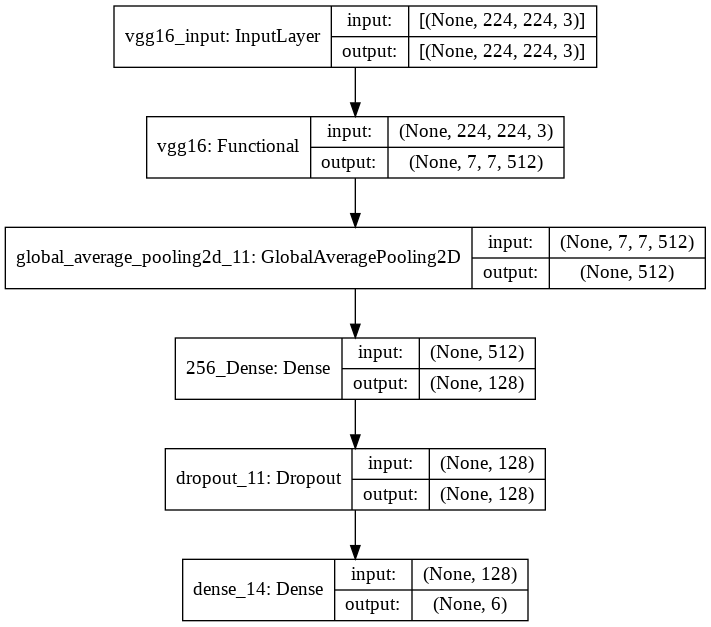

In [94]:
model = VGG_16('categorical_crossentropy', ['accuracy', 'Precision', 'Recall'], 'adam', num_classes)
model = model.vgg_model()

plot_model(model, to_file='vgg_model.png', show_shapes=True, show_layer_names=True)

In [95]:
model.summary()

Model: "sequential_14"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
vgg16 (Functional)           (None, 7, 7, 512)         14714688  
_________________________________________________________________
global_average_pooling2d_11  (None, 512)               0         
_________________________________________________________________
256_Dense (Dense)            (None, 128)               65664     
_________________________________________________________________
dropout_11 (Dropout)         (None, 128)               0         
_________________________________________________________________
dense_14 (Dense)             (None, 6)                 774       
Total params: 14,781,126
Trainable params: 14,781,126
Non-trainable params: 0
_________________________________________________________________


In [88]:
# Defining our callbacks
from livelossplot import PlotLossesKeras
c1=PlotLossesKeras()
c2= EarlyStopping(
    monitor="val_loss",
    min_delta=0,
    patience=6,
    mode="auto",
    baseline=None,
    restore_best_weights=True,
)

c3= ReduceLROnPlateau(
    monitor="val_loss",
    factor=0.1,
    patience=3,
    mode="auto",
    min_delta=0.0001,
    cooldown=0,
    min_lr=0.001
)
if not os.path.exists("./VGG16"):
    os.mkdir("./VGG16")

c4 = ModelCheckpoint('./VGG16/vgg16_model_weights-improvement-{epoch:02d}-{val_accuracy:.2f}.hdf5',
                    monitor = 'val_loss',
                    save_best_only = True,
                    save_weights_only = True,
                    mode = 'min'
                     )

callbacks = [c1, c2, c3, c4]

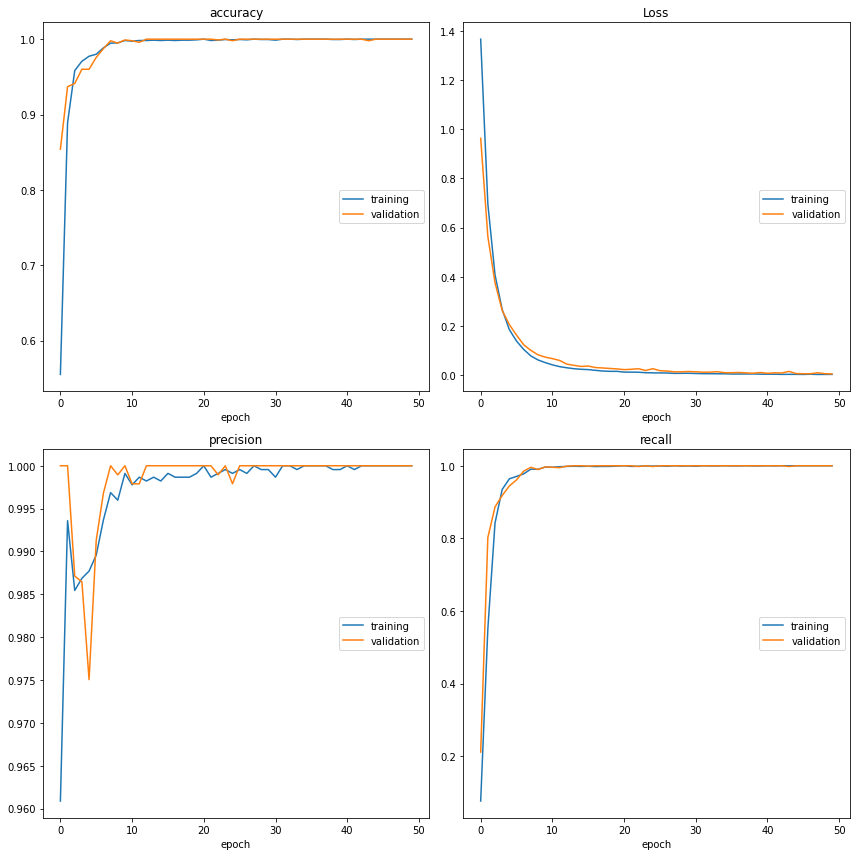

accuracy
	training         	 (min:    0.555, max:    1.000, cur:    1.000)
	validation       	 (min:    0.854, max:    1.000, cur:    1.000)
Loss
	training         	 (min:    0.003, max:    1.367, cur:    0.003)
	validation       	 (min:    0.005, max:    0.963, cur:    0.005)
precision
	training         	 (min:    0.961, max:    1.000, cur:    1.000)
	validation       	 (min:    0.975, max:    1.000, cur:    1.000)
recall
	training         	 (min:    0.076, max:    1.000, cur:    1.000)
	validation       	 (min:    0.211, max:    1.000, cur:    1.000)


In [89]:
vgg16_training_history = model.fit_generator(train_gen,
                                       validation_data=val_gen,                                        
                                        epochs=50,                                        
                                        steps_per_epoch =2252/64,
                                        validation_steps = 952/64,
                                        verbose=1,
                                        callbacks=callbacks)

In [90]:
def process_image(image):

    if image.mode != "RGB":
        image = image.convert("RGB")
    
    img = image.resize((224,224))
    img = img_to_array(img)
    img = img.astype('float32')
    img /= 255.0
    img = np.array([img])
    return img

os.listdir(masked_data)

['Rudra', 'Ashish', 'Ajita', 'Aradhana', 'Komal', 'Aayush']

In [91]:
train_gen.class_indices

{'Aayush': 0, 'Ajita': 1, 'Aradhana': 2, 'Ashish': 3, 'Komal': 4, 'Rudra': 5}

In [92]:
test_classes = os.listdir(val_data)
prediction_classes = list(train_gen.class_indices.keys())

unmasked_predictions = {
               "Komal":[],
               "Ashish":[],
               "Rudra":[],
               "Aradhana":[],
               "Aayush":[],
               "Ajita":[]}
print("FOR UN_MASKED IMAGES")
for class_ in test_classes:
    print(f"Searching inside {class_} folder")
    images = os.listdir(os.path.join(val_data + f"/{class_}"))
    for img in images:
        image = Image.open(val_data + f"/{class_}" + f"/{img}")        
        image = process_image(image)
        model_pred = np.argmax(model.predict(image))
        unmasked_predictions[class_].append(prediction_classes[model_pred])


test_classes = list(train_gen.class_indices.keys())


masked_predictions = {
               "Komal":[],
               "Ashish":[],
               "Rudra":[],
               "Aradhana":[],
               "Aayush":[],
               "Ajita":[]}
print("\n")               
print("FOR MASKED IMAGES")
for class_ in test_classes:
    print(f"Searching inside {class_} folder")
    images = os.listdir(os.path.join(masked_data + f"/{class_}"))
    for img in images:
        image = Image.open(masked_data + f"/{class_}" + f"/{img}")        
        image = process_image(image)
        model_pred = np.argmax(model.predict(image))
        masked_predictions[class_].append(prediction_classes[model_pred])

FOR UN_MASKED IMAGES
Searching inside Rudra folder
Searching inside Ashish folder
Searching inside Ajita folder
Searching inside Aradhana folder
Searching inside Komal folder
Searching inside Aayush folder


FOR MASKED IMAGES
Searching inside Aayush folder
Searching inside Ajita folder
Searching inside Aradhana folder
Searching inside Ashish folder
Searching inside Komal folder
Searching inside Rudra folder


In [93]:
un_masked_preds = []
un_masked_labels = []

for key in unmasked_predictions.keys():
    for val in unmasked_predictions[key]:
        un_masked_preds.append(val)
        un_masked_labels.append(key)
print("FOR UN_MASKED IMAGES")
print(classification_report(un_masked_preds, un_masked_labels));

masked_preds = []
masked_labels = []

print("\n")
print("FOR MASKED IMAGES")
for key in masked_predictions.keys():
    for val in masked_predictions[key]:
        masked_preds.append(val)
        masked_labels.append(key)
print(classification_report(masked_preds, masked_labels));

FOR UN_MASKED IMAGES
              precision    recall  f1-score   support

      Aayush       1.00      0.98      0.99       185
       Ajita       1.00      1.00      1.00       200
    Aradhana       1.00      1.00      1.00       201
      Ashish       0.98      1.00      0.99        82
       Komal       0.99      1.00      1.00       100
       Rudra       1.00      1.00      1.00       184

    accuracy                           1.00       952
   macro avg       0.99      1.00      1.00       952
weighted avg       1.00      1.00      1.00       952



FOR MASKED IMAGES
              precision    recall  f1-score   support

      Aayush       0.27      0.20      0.23       141
       Ajita       1.00      1.00      1.00       100
    Aradhana       0.00      0.00      0.00         0
      Ashish       0.90      0.38      0.53       119
       Komal       1.00      0.43      0.60       178
       Rudra       0.00      0.00      0.00         3

    accuracy                        